In [30]:
import os
import shutil
global starname
#make a folder called 'wfun'
def mkdir(path):
    path = path.strip()
    path = path.rstrip("\\")
    isExists = os.path.exists(path)
    if not isExists:
        os.makedirs(path)
        return True
    else:
        return False


In [31]:

#Save to a file for this star.

#get our currently working folder
source_folder = os.getcwd()
#create a folder call wfun (we can change it to anything else if we are trying to reuse it)
wfun_path = os.path.join(source_folder, 'wfun')
wfun_check_path = os.path.join(source_folder, 'wfun_check')
mkdir(wfun_path)
mkdir(wfun_check_path)

False

In [32]:
from PIL import Image, ImageDraw, ImageFont
#scan the file list so that we could put it in
def scan_file(source_folder, extension=".fits"):
    wfun_list = os.listdir(wfun_check_path)
    file_list = os.listdir(source_folder)
    specific_files = [file for file in file_list if file.lower().startswith("ecfzst") and file.lower().endswith(extension.lower()) ]
    return wfun_list,specific_files


def check_info():
    return None


def write_io(info_file,info): #Function to write picture to a file
    # if isinstance(info, str):
    #     # Write in text mode
    with open(info_file+'\\check_information.txt', 'a') as f:
        f.write(info)
    # else:
    #     with open(info_file+'\\check\\'+starname+'.png', 'wb') as f:
    #         f.write(info)



def combine_images_grid(image_paths, output_path, grid_size):
    images = [Image.open(path) for path in image_paths]
    width, height = images[0].size
    
    # Calculate the size of the combined image
    combined_width = width * grid_size[0]
    combined_height = height * grid_size[1]
    
    combined_image = Image.new('RGB', (combined_width, combined_height))
    
    for index, image in enumerate(images):
        x_offset = (index % grid_size[0]) * width
        y_offset = (index // grid_size[0]) * height
        combined_image.paste(image, (x_offset, y_offset))
    
    combined_image.save(output_path)

In [33]:
#Load packages and functions

import numpy as np
import astropy.io.fits as fits
import glob
import matplotlib.pyplot as plt
import astropy
from astropy import modeling
from scipy.signal import argrelextrema
from scipy import asarray as ar, exp, sqrt
from scipy.optimize import curve_fit

#wavelength, flux
def wf(dat): #whichord,dat. Setup:   w,f=wf(#,dat)
    w=np.array([d[0] for d in dat])
    f=np.array([d[1] for d in dat])
    return w,f

#Ultimate opendat:
def opendatt(dir,filename,spl=''): #dir,'filename'. For opening a data file. Can then send through roundtable.
    f=open(dir+filename,'r')
    dat=f.readlines()
    f.close()
    if spl=='':
        labels=dat[0][0:-1].split()
        dat2=[[a.strip('\n') for a in d.split()] for d in dat if d[0]!='#']
    else:
        labels=dat[0][0:-1].split(spl)
        dat2=[[a.strip('\n') for a in d.split(spl)] for d in dat if d[0]!='#']
    dat3=[['nan' if a.strip()=='' else a for a in d] for d in dat2]
    return [dat3,labels]

def opendat(dirr,filename,params,splitchar=''): #Use as var,var,var...=opendat(dir,'filename',['keys']).
    if splitchar=='':
        dat,label=opendatt(dirr,filename)
    else:
        dat,label=opendatt(dirr,filename,splitchar)  #Get keys by first leaving ['keys'] blank: opendat(dirr,filename,[])
    print(label)
    varrs=[]
    for i in range(len(params)):
        j=label.index(params[i])
        try:
            var=np.array([float(d[j]) for d in dat]) #works for float.
            varrs.append(var)
        except ValueError:
            var=[d[j].strip() for d in dat] #works for strings.
            varrs.append(var)
    if len(params)==1:
        varrs=varrs[0]
    return varrs

def writedat(dirr,filename,pars,label): #.dat auto included. pars as [name,ra,dec] etc.
    datp=[[str(a[i]) for a in pars] for i in range(len(pars[0]))]
    f=open(dirr+filename+'.dat','w')
    print('\t'.join(label),file=f)
    print(label)
    for d in datp:
        print('\t'.join(d),file=f)
    f.close()
    print('It is written: '+filename+'.dat')

In [34]:
#Open laboratory Ne lines:
wN,fN=opendat('',r'C:\Users\ZY\Documents\github\233boy\StarsinRadiationEnvironment\NeLines.dat',['#wavelength','flux'])

#Open e-fits file:
def efits(file):
    hdu=fits.open(file)
    data=hdu[0].data
    head=hdu[0].header
    hdu.close()
    return data,head #flux

#Define pixel-center-finding function:
#Operates on e..._comp.fits files.
starfile=r'C:\Users\ZY\Downloads\ecfzst_0056_CG4_8.fits'
fstar,head=efits(starfile)

def fileprocess(lampfile):
    flamp,head=efits(lampfile)
    starname=head['Object']
    identity=head['GSP_FNAM']
    #draw the graph and save the picture
    w,count=wcal(flamp)
    # Paths to the images to combine
    image_paths = scan_file(source_folder+'\\wfun_check', extension=".png")
    
    # Path to the output image
    output_path = source_folder+'\\wfun_check\\'+starname+'_'+identity+'.jpg'
    
    # Combine images in a designed grid
    combine_images_grid(image_paths, output_path, (count//4,5))
    delfile=scan_file(source_folder+'\\wfun_check', extension=".png")
    for i in delfile:
        os.remove(i)
    writedat(source_folder+'\\wfun\\','wfun_'+identity,[w,fstar],['#w','f'])


def centralpixels(f,pltt='y'): #give flux from e-type comp file, toggle plots; compare to lab Ne at end
    maxx=[i for i in argrelextrema(f,np.greater)[0] if f[i]>10000]
    print(maxx)
    write_io(source_folder+'\\wfun_check',str(maxx)+'\r',starname)
    for m in maxx:
        write_io(source_folder+'\\wfun_check',f'{m}:{f[m]}'+'\r',starname)
    
        
    #check you got them all:
    if pltt=='y':
        plt.figure()
        plt.plot(f)
        plt.scatter(maxx,np.array(f)[np.array(maxx)],c='darkorange')
        plt.xlabel('pixel')
        plt.ylabel('flux count')
        plt.savefig(source_folder+'\\wfun_check\\'+starname+'scan')
    
    #Fit each maxx line peak out to 5000 flux counts:
    pcs=[] #pixel centers
    for i in range(len(maxx)):
        #go out left until below 5000, out right until below 5000
        cp=maxx[i] #central pixel
        b,e=cp-10,cp+10

        p=[] #left edge of line
        i=cp
        #print(f[i])
        while f[i]>5000 and abs(cp-i)<10:
            p.append(i)
            i-=1
        l=np.min(p)

        p=[] #right edge of line
        i=cp
        #print(f[i])
        while f[i]>5000 and abs(cp-i)<10:
            p.append(i)
            i+=1
        r=np.max(p)

        del p
        #print(l,r)

        pe=np.array(range(l,r)) #pixels of the emission line
        fe=np.array([f[i] for i in pe]) #fluxes of the emission line
        
        if pltt=='y':
            plt.figure()
            plt.plot(range(b,e),f[b:e])
            plt.plot(pe,fe)
            plt.xticks([b,l,cp,r,e])
            plt.xlabel('pixel')
            plt.ylabel('flux count')
        
        #fit a Gaussian to the emission line to find its center!

        PE = ar(pe)
        FE = ar(fe)

        n = len(FE)  ## <---
        mean = sum(FE*PE)/n
        sigma = sqrt(sum(FE*(PE-mean)**2)/n)

        def gaus(x,a,mu,sigma):
            return a*exp(-(x-cp-mu)**2/(2*sigma**2))

        popt,pcov = curve_fit(gaus,PE,FE)#,p0=[0.18,mean,sigma])  ## <--- leave out the first estimation of the parameters

        xx = np.linspace( cp-10, cp+10, 100 )  ## <--- calculate against a continuous variable
        pc=cp+popt[1] #central wavelength
        
        if pltt=='y':
            plt.figure()
            plt.scatter(PE, FE, label = "Measured",c='deepskyblue')
            plt.plot(xx,gaus(xx,*popt),c='darkorange',label='Fit')  ## <--- plot against the contious variable
            plt.scatter(pc,gaus(pc,*popt),zorder=10,marker='+',s=100,c='red')
            plt.xticks([b,l,cp,r,e])
            plt.xlabel('pixel')
            plt.ylabel('flux count')
            plt.savefig(source_folder+'\\wfun_check\\'+starname+'plot'+str(i))
        
        print('Pixel center of emission line:',pc)
        pcs.append(pc)
    
    #Check results against lab Ne
    print('\nNeon lines needed:',len(wN))
    print('emission lines found:',len(pcs))
    if len(wN)-len(pcs)>0:
        print('!!! line(s) not found!')
    plt.figure()
    plt.plot(f)
    for p in pcs:
        plt.plot([p,p],[np.min(f),np.max(f)],c='darkorange',alpha=0.5)
        plt.savefig(source_folder+'\\wfun_check\\'+starname+'check')
    
    return pcs,len(maxx)

# Make list of calibrated wavelengths:
def wcal(f,plttt='y'): #input e..._comp.fits comparison lamp file
    #find central pixel locations of lamp emission lines:
    pc,count=centralpixels(f,pltt=plttt)
    
    # Take list of pixel centers and laboratory neon line wavelengths and map pixels to wavelengths.
    wfitz,a,b,c,d=np.polyfit(pc,wN,3,full=True)
    print(a[0])

    x=range(len(f))
    wfit=np.poly1d(wfitz)
    w=wfit(x)
    if plttt=='y':
        plt.figure()
        plt.scatter(pc,wN)
        plt.plot(x,w)
        plt.savefig(source_folder+'\\wfun_check\\'+starname+'linecheck')
    return w,count

#look at results and see if Ha is in right place:
def plotspec(w,fstar):
    plt.figure()
    plt.plot(w,fstar)
    plt.plot([6563,6563],[np.min(fstar),np.max(fstar)],c='red',lw=1)
    plt.xlabel('Wavelength (A)')
    plt.ylabel('Flux Counts')

['#wavelength', 'flux']


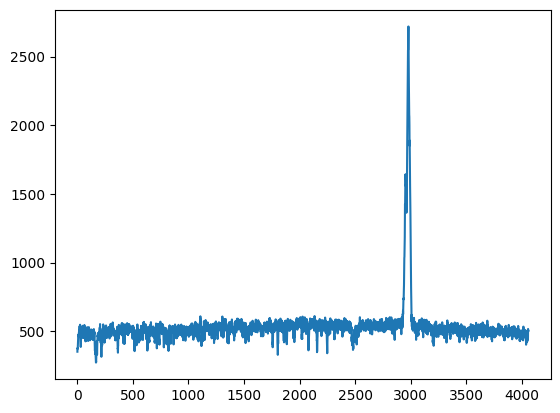

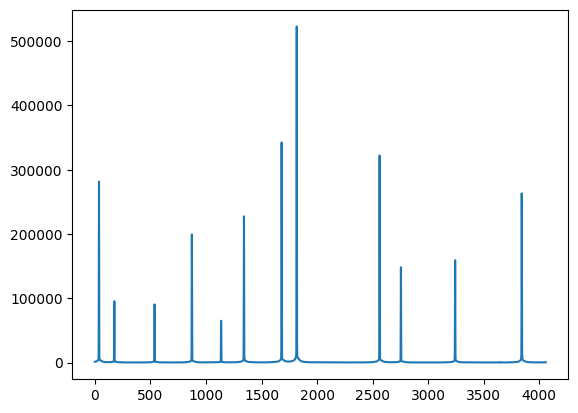

In [35]:
#Get fluxes from opening e-files.

#star
starfile=r'C:\Users\ZY\Downloads\ecfzst_0056_CG4_8.fits'
fstar,head=efits(starfile)
#check:
plt.figure()
plt.plot(fstar)

#comparison lamp
lampfile=r'C:\Users\ZY\Downloads\ecfzst_0057_CG4_8_comp_165.98-175.83.fits'
flamp,header=efits(lampfile)
#check:
plt.figure()
plt.plot(flamp)

In [36]:
#Run wavelength calibration on comparison lamp file.
print(f'opening file: {lampfile}')
w=wcal(flamp)

opening file: C:\Users\ZY\Downloads\ecfzst_0057_CG4_8_comp_165.98-175.83.fits
[37, 175, 537, 873, 1136, 1342, 1681, 1817, 2563, 2755, 3243, 3842]


NameError: name 'starname' is not defined

In [37]:
#Assign calibrated wavelengths to star flux. Check how it looks:
plotspec(w,fstar)
print(starfile)



NameError: name 'w' is not defined

What should we do to make the process automatically???

make two folder: wfun(dataset) and wfun_check(checked information)

feature:
process all the .fit file(scan_file()) to wfun file and put it into the wfun folder(mkdir(),writedat())
put all the information that needed and name it as wfun_check file: including picture and also text information



In [38]:




#find the file list 
wfun,files = scan_file(source_folder, extension=".fits")
print(source_folder)
print(files)

for lampfile in files:
    fileprocess(lampfile)
    
# #Run wavelength calibration on comparison lamp file.
# write_io(source_folder+'\\wfun_check',f"opening file: {lampfile}, name:{starname}+'\r'",starname)


# lampfile=r'C:\Users\ZY\Downloads\ecfzst_0057_CG4_8_comp_165.98-175.83.fits'


# #write the check info and combine the picture


c:\Users\ZY\Documents\github\233boy\Dr.-Yep-2024-summer-research\Day1\RED
['ecfzst_0084_HD36003.fits', 'ecfzst_0088_HD36003_comp_159.09-166.91.fits', 'ecfzst_0089_HD32450.fits', 'ecfzst_0090_HD32450_comp_157.22-165.46.fits', 'ecfzst_0091_HD42581.fits', 'ecfzst_0092_HD42581_comp_159.66-168.85.fits', 'ecfzst_0093_CG4_1.fits', 'ecfzst_0094_CG4_1_comp_159.99-168.55.fits', 'ecfzst_0095_CG4_3.fits', 'ecfzst_0096_CG4_3_comp_159.13-168.39.fits', 'ecfzst_0097_CG4_5.fits', 'ecfzst_0098_CG4_5_comp_161.00-169.57.fits', 'ecfzst_0099_CG4_6.fits', 'ecfzst_0100_CG4_6_comp_158.36-169.07.fits', 'ecfzst_0101_CG30_11.fits', 'ecfzst_0102_CG30_11_comp_162.10-170.51.fits', 'ecfzst_0103_CG30_12_target_1.fits', 'ecfzst_0103_CG30_12_target_2.fits', 'ecfzst_0104_CG30_12_comp_target_1_201.86-210.56.fits', 'ecfzst_0104_CG30_12_comp_target_2_200.00-212.42.fits', 'ecfzst_0105_CG30_13_target_1.fits', 'ecfzst_0105_CG30_13_target_2.fits', 'ecfzst_0105_CG30_13_target_3.fits', 'ecfzst_0106_CG30_13_comp_target_1_181.86-19

NameError: name 'starname' is not defined

In [39]:

lampfile=r'C:\Users\ZY\Documents\github\233boy\Dr.-Yep-2024-summer-research\Day1\RED\ecfzst_0084_HD36003.fits'
with fits.open(lampfile) as fit:
    head=fit[0].header['GSP_FNAM']
    print(head)

ecfzst_0084_HD36003.fits
